In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.read_csv('train.csv', sep = ';')
df.sample(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
17145,45,technician,single,secondary,no,586,no,yes,cellular,28,jul,32,3,-1,0,unknown,no
1994,27,technician,single,secondary,no,769,yes,no,unknown,9,may,317,2,-1,0,unknown,no


In [2]:
cats = df.select_dtypes(include = ['object']).columns
nums = df.select_dtypes(include = ['int64', 'float64']).columns

cats, nums

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'y'],
       dtype='object'),
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

In [17]:
for i in nums:
    if (df[i] < 0).any():
        print(f'{i} contains {len(df[df[i] < 0])} negative values')

balance contains 3766 negative values
pdays contains 36954 negative values


In [111]:
print(f'Before removing outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))
for col in ['balance']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries
    
df = df[filtered_entries]

print(f'After removing outlier: {len(df)}')

Before removing outlier: 45211
After removing outlier: 40482


In [112]:
X = df.drop(columns=['y'])
y = df[['y']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 18)

In [113]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

In [114]:
col = ['job', 'education', 'contact']

for i in col:
    print(f"{i} unknown: {round(len(df[df[i].isin(['unknown'])]) / len(df) * 100, 2)}%")

job unknown: 0.62%
education unknown: 4.04%
contact unknown: 29.26%


In [115]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

col = ['job', 'education']

for i in col:
    train[i] = train[i].replace('unknown', df[i].mode()[0])
    test[i] = test[i].replace('unknown', df[i].mode()[0])

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

In [116]:
col = ['job', 'education', 'contact']

for i in col:
    print(f"{i} unknown train set: {round(len(train[train[i].isin(['unknown'])]) / len(train) * 100, 2)}%")
    print(f"{i} unknown test set: {round(len(test[test[i].isin(['unknown'])]) / len(test) * 100, 2)}%")

job unknown train set: 0.0%
job unknown test set: 0.0%
education unknown train set: 0.0%
education unknown test set: 0.0%
contact unknown train set: 29.27%
contact unknown test set: 29.23%


In [117]:
X_train['is_married'] = X_train['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_test['is_married'] = X_test['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_train['education_mapped'] = X_train['education'].map({'primary' : 0,
                                                        'secondary' : 1,
                                                        'tertiary' : 2})

X_test['education_mapped'] = X_test['education'].map({'primary' : 0,
                                                      'secondary' : 1,
                                                      'tertiary' : 2})

X_train['is_default'] = X_train['default'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_default'] = X_test['default'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_housing'] = X_train['housing'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_housing'] = X_test['housing'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_loan'] = X_train['loan'].map({'no' : 0,
                                          'yes' : 1})

X_test['is_loan'] = X_test['loan'].map({'no' : 0,
                                        'yes' : 1})

y_train['y'] = y_train['y'].map({'no' : 0,
                                 'yes' : 1})

y_test['y'] = y_test['y'].map({'no' : 0,
                               'yes' : 1})

In [118]:
X_train = X_train.drop(columns = list(X_train.select_dtypes(include = ['object']).columns) + ['job', 'marital', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'])
X_test = X_test.drop(columns = list(X_test.select_dtypes(include = ['object']).columns) + ['job', 'marital', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'])

In [12]:
X_train.columns, display(len(X_train.columns))

7

(Index(['age', 'balance', 'is_married', 'education_mapped', 'is_default',
        'is_housing', 'is_loan'],
       dtype='object'),
 None)

In [119]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE(random_state = 18).fit_resample(X_train, y_train)

In [14]:
len(X_train_over), len(y_train_over), len(X_train), len(y_train), len(X_test), len(y_test)

(50268, 50268, 28337, 28337, 12145, 12145)

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def eval_classification():
    
    list_model = {'Logistic Regression' : LogisticRegression(random_state = 18),
                  'KNN Classifier' : KNeighborsClassifier(),
                  'Decision Tree Classifier' : DecisionTreeClassifier(random_state = 18),
                  'Random Forest Classifier' : RandomForestClassifier(random_state = 18),
                  'AdaBoost Classifier' : AdaBoostClassifier(random_state = 18),
                  'XGBoost Classifier' : XGBClassifier(random_state = 18)}
    
    for key, val in list_model.items():
        model = val
        model.fit(X_train_over, y_train_over)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)

        print(key, "Evaluation Result")
        print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
        print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
        print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
        print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
        print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
        print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
        print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
        print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
        print("")

In [122]:
eval_classification()

Logistic Regression Evaluation Result
Accuracy (Train Set): 0.62
Accuracy (Test Set): 0.61
Precision (Train Set): 0.18
Precision (Test Set): 0.16
Recall (Train Set): 0.64
Recall (Test Set): 0.62
F1-Score (Train Set): 0.28
F1-Score (Test Set): 0.26

KNN Classifier Evaluation Result
Accuracy (Train Set): 0.82
Accuracy (Test Set): 0.71
Precision (Train Set): 0.38
Precision (Test Set): 0.19
Recall (Train Set): 0.86
Recall (Test Set): 0.49
F1-Score (Train Set): 0.52
F1-Score (Test Set): 0.27

Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.78
Precision (Train Set): 0.97
Precision (Test Set): 0.20
Recall (Train Set): 0.88
Recall (Test Set): 0.32
F1-Score (Train Set): 0.92
F1-Score (Test Set): 0.24

Random Forest Classifier Evaluation Result
Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.79
Precision (Train Set): 0.92
Precision (Test Set): 0.22
Recall (Train Set): 0.92
Recall (Test Set): 0.36
F1-Score (Train Set): 0.92
F1-Score (Test Set): 0.27


In [108]:
from sklearn.model_selection import KFold, RandomizedSearchCV

model = AdaBoostClassifier(random_state = 18)

rand = dict()
rand['learning_rate'] = [0.05]
rand['algorithm'] = ['SAMME', 'SAMME.R']
rand['base_estimator'] = [LogisticRegression(C = 0.0011080808080808082, penalty = 'l2', random_state = 18)]

cv = KFold(n_splits=10)
rand_search = RandomizedSearchCV(estimator=model, param_distributions=rand, n_jobs=-1, cv=cv, scoring='recall')
rand_result = rand_search.fit(X_train_over, y_train_over)
y_pred = rand_result.predict(X_test)
y_pred_train = rand_result.predict(X_train)
y_pred_proba = rand_result.predict_proba(X_test)
y_pred_proba_train = rand_result.predict_proba(X_train)

print(f'Best Parameter: {rand_result.best_params_}')
print(f'Best Score: {rand_result.best_score_}')
print('')

print("Tuned Adaboost Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'learning_rate': 0.05, 'base_estimator': LogisticRegression(C=0.0011080808080808082, random_state=18), 'algorithm': 'SAMME'}
Best Score: 0.6

Tuned Adaboost Classifier
Accuracy (Train Set): 0.61
Accuracy (Test Set): 0.60
Precision (Train Set): 0.17
Precision (Test Set): 0.16
Recall (Train Set): 0.63
Recall (Test Set): 0.61
F1-Score (Train Set): 0.27
F1-Score (Test Set): 0.25


In [123]:
from sklearn.model_selection import GridSearchCV

params = {'penalty' : ['l1', 'l2'],
          'C' : [0.0011080808080808082],
          'solver' : ['lbfgs', 'sag','saga']}

model = GridSearchCV(LogisticRegression(random_state = 18), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_estimator_.get_params()}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Logistic Regression")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'C': 0.0011080808080808082, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 18, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best Score: 0.64

Tuned Logistic Regression
Accuracy (Train Set): 0.61
Accuracy (Test Set): 0.60
Precision (Train Set): 0.17
Precision (Test Set): 0.16
Recall (Train Set): 0.65
Recall (Test Set): 0.63
F1-Score (Train Set): 0.27
F1-Score (Test Set): 0.26


Text(1.9722222222222232, 0.5, 'Actual')

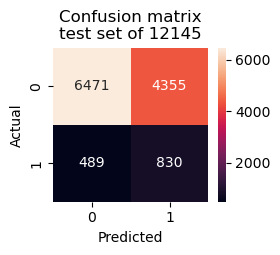

In [124]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize = (2.5,2))
sns.heatmap((confusion_matrix(y_test, y_pred)), annot = True, fmt = '.0f', ax = fig.add_subplot(1,1, 1))
plt.title(f'Confusion matrix\ntest set of {len(y_test)}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

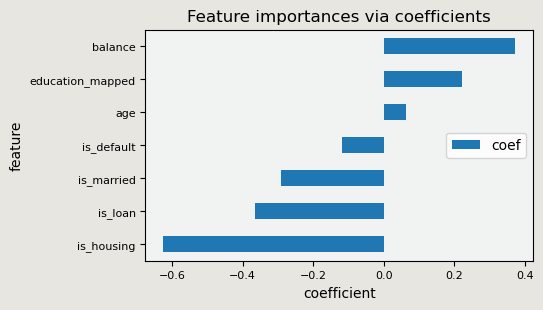

In [125]:
importance = np.abs(model.best_estimator_.coef_)
feature_names = np.array(X_train.columns)
plt.figure(figsize = (5, 3), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
pd.DataFrame(list(zip(list(X_train.columns), list(model.best_estimator_.coef_[0]))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)\
            .plot(x = 'feature', kind = 'barh', fontsize = 8, ax = ax)
plt.title("Feature importances via coefficients")
plt.xlabel('coefficient')
plt.legend(loc = 'center right')

In [126]:
list(zip(list(X_train.columns), list(model.best_estimator_.coef_[0])))

[('age', 0.06258163666803032),
 ('balance', 0.3725496643754),
 ('is_married', -0.29124857298042206),
 ('education_mapped', 0.2203991613390367),
 ('is_default', -0.11937858413662669),
 ('is_housing', -0.6258916732962359),
 ('is_loan', -0.3640130596979508)]

param value: 0.0001; train: 0.6312831720262254; test: 0.6095526914329037
param value: 0.0006040404040404041; train: 0.6403371838901031; test: 0.6186504927975739
param value: 0.0011080808080808082; train: 0.6475179519200749; test: 0.6292645943896892
param value: 0.0016121212121212123; train: 0.6409615985014049; test: 0.620166793025019
param value: 0.002116161616161616; train: 0.6387761473618483; test: 0.6178923426838514
param value: 0.0026202020202020205; train: 0.6390883546674992; test: 0.6148597422289613
param value: 0.0031242424242424243; train: 0.6362784889166406; test: 0.6163760424564063
param value: 0.003628282828282828; train: 0.6359662816109897; test: 0.6171341925701289
param value: 0.004132323232323233; train: 0.6356540743053387; test: 0.6178923426838514
param value: 0.004636363636363637; train: 0.6359662816109897; test: 0.6194086429112965
param value: 0.0051404040404040416; train: 0.6369029035279425; test: 0.6186504927975739
param value: 0.005644444444444445; train: 0.63627848

param value: 0.048487878787878795; train: 0.6418982204183578; test: 0.6224412433661866
param value: 0.0489919191919192; train: 0.6418982204183578; test: 0.6224412433661866
param value: 0.0494959595959596; train: 0.6418982204183578; test: 0.6224412433661866
param value: 0.05; train: 0.6418982204183578; test: 0.6224412433661866


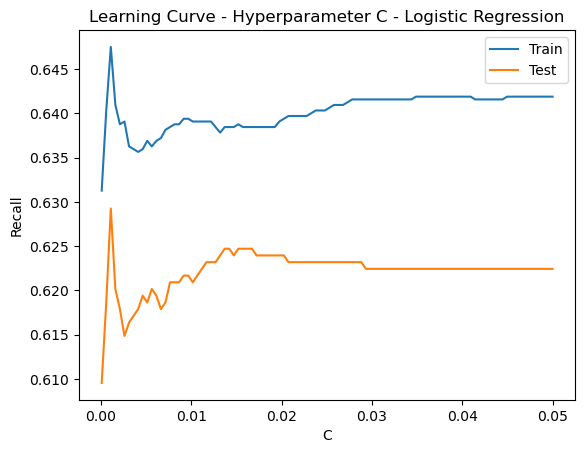

In [99]:
param_values = [float(x) for x in np.linspace(0.0001, 0.05, 100)]

train_scores = []
test_scores = []

for c in param_values:
    model = LogisticRegression(penalty='l2', C=c, random_state = 18)
    model.fit(X_train_over, y_train_over)

    y_pred_train = model.predict(X_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_scores.append(train_recall)

    y_pred = model.predict(X_test)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(c) + '; train: ' + str(train_recall) + '; test: '+ str(test_recall))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.xlabel('C')
plt.ylabel('Recall')
plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
plt.legend()
plt.show()